<a href="https://colab.research.google.com/github/Shrilaxmi-21/spam-detection/blob/main/spamdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset (assuming it's a CSV file)
df = pd.read_csv('/content/drive/MyDrive/Adv/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]  # Selecting only 'Label' and 'Message' columns
df.columns = ['label', 'message']  # Rename columns for clarity
print(df.head())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
import re
import string

# Function to clean the text
def clean_text(text):
    # Remove numbers and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = text.strip()
    return text

# Apply cleaning function to each message
df['message'] = df['message'].apply(clean_text)
print(df.head())


  label                                            message
0   ham  go until jurong point crazy available only in ...
1   ham                            ok lar joking wif u oni
2  spam  free entry in  a wkly comp to win fa cup final...
3   ham        u dun say so early hor u c already then say
4   ham  nah i dont think he goes to usf he lives aroun...


In [ ]:
# Convert 'spam' to 1 and 'ham' to 0
df['label'] = df['label'].map({'spam': 1, 'ham': 0})
print(df.head())


   label                                            message
0      0  go until jurong point crazy available only in ...
1      0                            ok lar joking wif u oni
2      1  free entry in  a wkly comp to win fa cup final...
3      0        u dun say so early hor u c already then say
4      0  nah i dont think he goes to usf he lives aroun...


In [ ]:
from sklearn.model_selection import train_test_split

X = df['message']
y = df['label']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")


Training data size: 4457
Testing data size: 1115


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, and transform the test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Shape of training data: {X_train_tfidf.shape}")
print(f"Shape of test data: {X_test_tfidf.shape}")


Shape of training data: (4457, 5000)
Shape of test data: (1115, 5000)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9632286995515695
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.73      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115

Confusion Matrix:
 [[965   0]
 [ 41 109]]


In [ ]:
from sklearn.model_selection import GridSearchCV

# Example grid search for Logistic Regression
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200]
}

logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'C': 10, 'max_iter': 100}


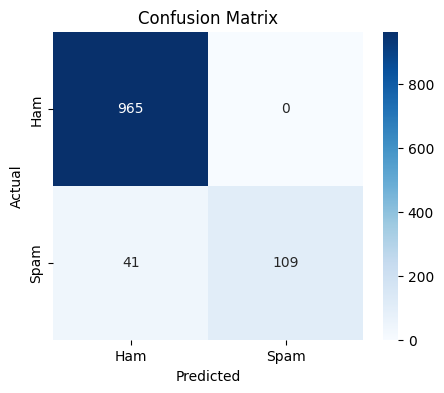

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
def detect_spam_with_probability(message):
    message = clean_text(message)
    vector = vectorizer.transform([message])

    prediction = model.predict(vector)[0]
    probability = model.predict_proba(vector)[0][1]

    return prediction, probability


In [ ]:
msg = "Win ₹100000 cash prize now!!!"
pred, prob = detect_spam_with_probability(msg)

print("Prediction:", "SPAM" if pred == 1 else "NOT SPAM")
print("Spam Probability:", round(prob*100, 2), "%")


Prediction: SPAM
Spam Probability: 91.91 %


In [ ]:
import pickle

# Save model
with open("spam_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


In [ ]:
# Load model
with open("spam_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Load vectorizer
with open("tfidf_vectorizer.pkl", "rb") as f:
    loaded_vectorizer = pickle.load(f)


In [ ]:
def detect_spam_loaded_model(message):
    message = clean_text(message)
    vector = loaded_vectorizer.transform([message])
    prediction = loaded_model.predict(vector)[0]

    return "🚨 SPAM" if prediction == 1 else "✅ NOT SPAM"
print(detect_spam_loaded_model("Free recharge offer valid today only"))
print(detect_spam_loaded_model("Call me when you reach home"))


🚨 SPAM
✅ NOT SPAM


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_vec, y_train, cv=5)

print("Cross-validation accuracy:", scores.mean())


Cross-validation accuracy: 0.9571459487752462


In [ ]:
!pip install gradio scikit-learn pandas


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import pickle

# Load dataset (if you have spam.csv, upload it via Colab)
df = pd.read_csv("/content/drive/MyDrive/Adv/spam.csv", encoding="latin-1")[['v1','v2']]
df.columns = ['label', 'message']

# Convert labels to numbers
df['label'] = df['label'].map({'ham':0, 'spam':1})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)

# Create pipeline: TF-IDF + Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('nb', MultinomialNB())
])

# Train model
pipeline.fit(X_train, y_train)

# Save the model (optional)
with open("spam_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("Model trained successfully ✅")


Model trained successfully ✅


In [ ]:
# Extra spam messages to improve detection
extra_spam = [
    "Click here to unlock your special prize today",
    "Claim your free lottery ticket now",
    "Win a free iPhone instantly"
]

# Add labels
extra_labels = [1] * len(extra_spam)

# Append to dataset
df_extra = pd.DataFrame({'message': extra_spam, 'label': extra_labels})
df = pd.concat([df, df_extra], ignore_index=True)

# Now do the train-test split
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)


In [ ]:
import gradio as gr

# Function to predict spam
def detect_spam(message):
    prediction = pipeline.predict([message])[0]
    if prediction == 1:
        return "🚨 SPAM"
    else:
        return "✅ NOT SPAM"

# Create Gradio interface
iface = gr.Interface(
    fn=detect_spam,
    inputs=gr.Textbox(lines=5, placeholder="Enter your message here..."),
    outputs="text",
    title="📩 Spam Detection App",
    description="Enter a message to check whether it is Spam or Not Spam"
)

# Launch the app
iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3813894348014b82b6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
def detect_spam_prob(message):
    prob = pipeline.predict_proba([message])[0][1]
    pred = pipeline.predict([message])[0]
    return f"{'🚨 SPAM' if pred==1 else '✅ NOT SPAM'} | Probability: {prob*100:.2f}%"

iface_prob = gr.Interface(
    fn=detect_spam_prob,
    inputs=gr.Textbox(lines=5, placeholder="Enter your message here..."),
    outputs="text",
    title="📩 Spam Detection App with Probability",
    description="Enter a message to check spam and probability"
)

iface_prob.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fda4341275a3811022.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
